## Setup

In [1]:
%set_env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


### Imports

In [2]:
import matplotlib.pyplot as plt
import IPython.display as display

import numpy as np
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as nn_func
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision

import sys
# setting path
sys.path.append('../lib')
import utils
import plots

### Device setup

In [3]:
device, use_cuda = utils.setup_device(use_cuda_if_possible = True)

Running GPU.


## Data

In [4]:
BATCH_SIZE = 64

In [5]:
data_train = torchvision.datasets.MNIST(root = '../data/mnist', train = True, download = True, transform = torchvision.transforms.ToTensor())
data_test = torchvision.datasets.MNIST(root = '../data/mnist', train = False, download = True, transform = torchvision.transforms.ToTensor())
data_loader_train = DataLoader(data_train, batch_size = BATCH_SIZE, shuffle = True)
data_loader_test = DataLoader(data_test, batch_size = BATCH_SIZE, shuffle = False)

## Model

In [6]:
class ConvMod(nn.Module):
    """Convolutional module containing a list of convolutional layers with ReLU activation and optional batch normalization and dropout."""
    def __init__(self, name, input_size, depth, channels, kernel_sizes, strides, paddings, poolings, batchnorms, dropouts):
        super(ConvMod, self).__init__()

        # Ensure that all parameter lists are long enough.
        assert len(channels) >= depth
        assert len(kernel_sizes) >= depth
        assert len(strides) >= depth
        assert len(paddings) >= depth
        assert len(poolings) >= depth
        assert len(batchnorms) >= depth
        assert len(dropouts) >= depth
        for kernel_size in kernel_sizes:
            assert kernel_size % 2 == 1, "Only odd kernel sizes are supported."
        for dropout in dropouts:
            assert 0 <= dropout and dropout <= 1, "Dropout must be between 0 and 1."

        # Calculate the size of the output of each convolutional layer (for each channel).
        conv_size = []
        for i in range(depth):
            conv_dim_reduction = kernel_sizes[i]-1-paddings[i]*2
            assert (input_size - conv_dim_reduction) % (strides[i]*poolings[i]) == 0
            conv_size.append(int((input_size - conv_dim_reduction)/strides[i]/poolings[i]))
            input_size = conv_size[i]
        for i in range(depth):
            print(f"{name} layer {i} output: size={conv_size[i]} channels={channels[i]}")

        # Calculate total size of the output of the convolutional layers.
        self.output_size = conv_size[-1]*conv_size[-1]*channels[-1]
        
        self.module_list = nn.ModuleList()
        in_channels = 1
        for i in range(depth):
            conv = nn.Conv2d(in_channels=in_channels, out_channels=channels[i], kernel_size=kernel_sizes[i], stride=strides[i], padding=paddings[i])
            in_channels = channels[i]
            pool = nn.MaxPool2d(poolings[i])
            batchnorm = nn.BatchNorm2d(channels[i]) if (batchnorms[i]) else nn.Identity()
            dropout = nn.Dropout(p=dropouts[i])

            self.module_list.append(nn.ModuleList([conv, pool, batchnorm, dropout]))
        
        self.hidden = [None] + [None for layer in self.module_list]
    
    def forward(self, x):
        self.hidden[0] = x
        for i, (conv, pool, batchnorm, dropout) in enumerate(self.module_list):
            x = conv(x)
            x = pool(x)
            x = nn_func.relu(x)
            x = batchnorm(x)
            x = dropout(x)
            self.hidden[i+1] = x
        
        return x
    
    def hidden(self):
        return self.hidden
    
    def total_output_size(self):
        """ Returns the size of the output of the convolutional layers. """
        return self.output_size

class DenseMod(nn.Module):
    def __init__(self, name, in_features, depth, features, batchnorms, dropouts):
        super(DenseMod, self).__init__()

        # Ensure that all parameter lists are long enough.
        assert in_features > 0
        assert depth > 0
        assert len(features) >= depth
        assert len(batchnorms) >= depth
        assert len(dropouts) >= depth
        for dropout in dropouts:
            assert 0 <= dropout and dropout <= 1, "Dropout must be between 0 and 1."
        for i in range(depth):
            print(f"{name} layer {i} output: size={features[i]}")

        self.module_list = nn.ModuleList()
        for i in range(depth):
            lin = nn.Linear(in_features=in_features, out_features=features[i])
            in_features = features[i]
            batchnorm = nn.BatchNorm1d(features[i]) if (batchnorms[i]) else nn.Identity()
            dropout = nn.Dropout(p=dropouts[i])

            self.module_list.append(nn.ModuleList([lin, batchnorm, dropout]))
        
        self.out_features = in_features

    def forward(self, x):
        for lin, batchnorm, dropout in self.module_list:
            x = lin(x)
            x = nn_func.relu(x)
            x = batchnorm(x)
            x = dropout(x)
            
        return x

    def total_output_size(self):
        return self.out_features

In [7]:
class Net(nn.Module):
    def __init__(self, conv_mod, dense_mod):
        super(Net, self).__init__()

        self._conv_mod = conv_mod
        self._dense_mod = dense_mod

        self.lin_out = nn.Linear(in_features=dense_mod.total_output_size(), out_features=10)
        self.softmax = nn.Softmax(dim=1)
    
    def conv_mod(self):
        return self._conv_mod
    
    def dense_mod(self):
        return self._dense_mod
    
    def forward(self, x):
        x = self._conv_mod(x).flatten(1)
        x = self._dense_mod(x)
        x = self.lin_out(x)
        return self.softmax(x)

In [8]:
conv_depth = 2
conv_kernel_sizes = [3, 3]
conv_mod = ConvMod(
    "conv",
    input_size = 28,
    depth = conv_depth,
    channels = [8, 8], 
    kernel_sizes = conv_kernel_sizes, 
    strides = [1 for _ in range(conv_depth)], 
    paddings = [int((kernel_size - 1)/2) for kernel_size in conv_kernel_sizes], 
    poolings = [2,2,2,2], 
    batchnorms = [True for _ in range(conv_depth)], 
    dropouts = [0.1 for _ in range(conv_depth)])

lin_depth = 1
lin_mod = DenseMod(
    "lin",
    in_features=conv_mod.total_output_size(),
    depth = lin_depth,
    features = [128],
    batchnorms = [True for _ in range(lin_depth)],
    dropouts = [0.1 for _ in range(lin_depth)]
)

conv layer 0 output: size=14 channels=8
conv layer 1 output: size=7 channels=8
lin layer 0 output: size=128


In [9]:
net = Net(conv_mod, lin_mod)
if use_cuda:
    net.cuda()

In [10]:
class RevNet(nn.Module):
    def __init__(self, conv_mod, dense_mod):
        super(RevNet, self).__init__()

        self._conv_mod = conv_mod
        self._dense_mod = dense_mod

        self.out = nn.Sequential(
            nn.Linear(in_features=dense_mod.total_output_size(), out_features=28*28),
            nn.Unflatten(1, torch.Size([28, 28]))
        )
    
    def conv_mod(self):
        return self._conv_mod
    
    def dense_mod(self):
        return self._dense_mod
    
    def forward(self, x):
        x = self._conv_mod(x).flatten(1)
        x = self._dense_mod(x)
        x = self.out(x)
        return x

In [11]:
rev_conv_depth = 2
rev_conv_kernel_sizes = [3, 3]
rev_conv_mod = ConvMod(
    "conv",
    input_size = 14,
    depth = conv_depth,
    channels = [8, 8], 
    kernel_sizes = conv_kernel_sizes, 
    strides = [1 for _ in range(conv_depth)], 
    paddings = [int((kernel_size - 1)/2) for kernel_size in conv_kernel_sizes], 
    poolings = [1,1,2,2], 
    batchnorms = [True for _ in range(conv_depth)], 
    dropouts = [0.1 for _ in range(conv_depth)])

rev_lin_depth = 1
rev_lin_mod = DenseMod(
    "lin",
    in_features=conv_mod.total_output_size(),
    depth = lin_depth,
    features = [128],
    batchnorms = [True for _ in range(lin_depth)],
    dropouts = [0.1 for _ in range(lin_depth)]
)

conv layer 0 output: size=14 channels=8
conv layer 1 output: size=14 channels=8
lin layer 0 output: size=128


In [12]:
rev_net = RevNet(rev_conv_mod, rev_lin_mod)
if use_cuda:
    rev_net.cuda()

## Base Training

### Tracking

In [13]:
def accuracy(output, target):
    output_digit = np.argmax(output)
    return 1 if output_digit == target else 0

eval_funcs = [
    {
        "label": "Accuracy",
        "ylim": (0,1),
        "func": lambda output, target, label: accuracy(output, target)
    }
]   

In [14]:
rev_eval_funcs = []

### Training

In [15]:
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 1e-5

In [16]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

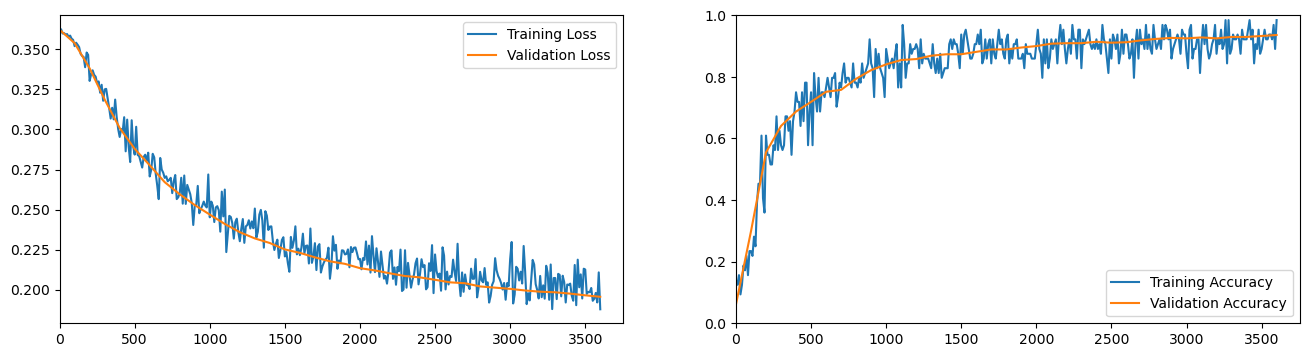

Average loss: 1.575813102722168


In [17]:
NUM_EPOCHS = 4
EVAL_EVERY = 100
NUM_VALIDATION_BATCHES = 10
LOG_TRAIN_EVERY = 10
LOG_EVERY = 200

epoch_size = len(data_loader_train)

NUM_BATCHES = epoch_size*NUM_EPOCHS


error_tracker = utils.ErrorTracker(criterion, eval_funcs, NUM_VALIDATION_BATCHES)

net.train()
for epoch in range(NUM_EPOCHS):
    for i, (inputs, labels) in enumerate(data_loader_train):
        index = epoch*epoch_size + i
        if index%EVAL_EVERY == 0:
            error_tracker.validation_update(index, net, data_loader_test)
        inputs = utils.to_torch(inputs)
        labels = utils.to_torch(labels)
        #print(labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        if index%LOG_TRAIN_EVERY == 0:
            error_tracker.training_update(index, outputs, labels, labels, loss)

        loss.backward()
        optimizer.step()

        if index % LOG_EVERY == 0:
            display.clear_output(wait=True)
            plots.plot_history(error_tracker, NUM_BATCHES, eval_funcs)
            plt.show()
net.eval()
avg_loss, _ = utils.test_net(net, data_loader_test, criterion, 50, eval_funcs)
print(f"Average loss: {avg_loss}")

## Input reconstruction

### Data

In [23]:
class ReconstructionData(torch.utils.data.Dataset):
    def __init__(self, net, dataset: torchvision.datasets.MNIST, get_intermediate):
        self.data = []
        for input, _ in dataset:
            utils.to_torch(input)
            net(input)
            intermediate = get_intermediate(net)
            self.data.append((intermediate, input))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        return self.data[index]

In [24]:
rev_train_data = ReconstructionData(net, data_train, lambda net: net.conv_mod().hidden()[1][0,0,:,:])
rev_eval_data = ReconstructionData(net, data_test, lambda net: net.conv_mod().hidden()[1][0,0,:,:])

rev_data_loader_train = DataLoader(rev_train_data, batch_size = BATCH_SIZE, shuffle = True)
rev_data_loader_test = DataLoader(rev_eval_data, batch_size = BATCH_SIZE, shuffle = False)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper___slow_conv2d_forward)

In [ ]:
rev_criterion = nn.MSELoss()

rev_optimizer = optim.AdamW(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [ ]:
NUM_EPOCHS = 4

rev_error_tracker = utils.ErrorTracker(criterion, rev_eval_funcs, NUM_VALIDATION_BATCHES)

rev_net.train()
for epoch in range(NUM_EPOCHS):
    for i, (inputs, labels) in enumerate(rev_data_loader_train):
        index = epoch*epoch_size + i
        if index%EVAL_EVERY == 0:
            rev_error_tracker.validation_update(index, rev_net, rev_data_loader_test)
        inputs = utils.to_torch(inputs)
        optimizer.zero_grad()
        outputs = rev_net(inputs)
        loss = rev_criterion(outputs, inputs)

        if index%LOG_TRAIN_EVERY == 0:
            rev_error_tracker.training_update(index, outputs, inputs, inputs, loss)

        loss.backward()
        optimizer.step()

        if index % LOG_EVERY == 0:
            display.clear_output(wait=True)
            plots.plot_history(rev_error_tracker, NUM_BATCHES, rev_eval_funcs)
            plt.show()
rev_net.eval()
avg_loss, _ = utils.test_net(rev_net, rev_data_loader_test, criterion, 50, rev_eval_funcs)
print(f"Average loss: {avg_loss}")